In [1]:
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import matplotlib.lines as mlines

import module_reseau_neurone as modN

In [2]:
N = 100 #number of neurons
Vseuil = 60 #the threshold of activation of neuron, in mV, global variable, used in functions
Vmax = 120 #90 #Vmax maximum can be attained
Vmin= -10 #-15 #Vmin minimum can be attained
Vmin_ma = -20
tau_min = 10
tau_max=20
tPA = 1 #0.2
deltaT = 0.1 #0.1
tPH = 0.6 #0.9
tH = 1.1 #1.1
alpha = 0.1 #0.1
nb_steps = 100 #number of simulation
beta=0.4 #beta*Vmax

modN.ini_params(N,Vseuil,Vmax,Vmin,Vmin_ma,tau_min,tau_max,tPA,deltaT,tPH,tH,alpha,nb_steps,beta)

In [3]:
Vt = modN.init_syst_potentiel()
C = modN.init_syst_links_weights()
Tt = modN.init_syst_state()
E = modN.init_syst_phase()
lamb = modN.init_syst_lambda()
Tar = modN.init_time_rest()
Cn,Ce,Ci=modN.decompose_syst_links_alcohol(C,np.array([]),np.array([]),np.array([]),0,0)

In [4]:
modN.start_syst(Vt, Tt, E)
res_potentials, res_states= modN.simulation(Vt, Cn,Ce,Ci, Tt, E, lamb, Tar, nb_steps)

In [ ]:
def simulation(syst_potentiel, syst_links_n,syst_links_e,syst_links_i, syst_state, syst_phase, syst_lambda, time_rest, nb_steps):
    """Return a list of all the matrixes, each matrix shows the potentials of the system
    at moment t"""
    # res_potentiels: list[matrix(N,N)]
    #res_states: list[matrix(N,1)]
    res_potentiels = []
    res_states = []


    new_p = copy.deepcopy(syst_potentiel)
    res_potentiels.append(new_p.copy())
    new_s = copy.deepcopy(syst_state)
    res_states.append(new_s)


    for i in range(nb_steps):
        
        new_p, new_s = modN.update_system(new_p, syst_links_n,syst_links_e, new_s, syst_phase, syst_lambda, time_rest)

        res_potentiels.append(copy.deepcopy(new_p))
        res_states.append(copy.deepcopy(new_s))
        
    return (res_potentiels, res_states)

In [ ]:
start_syst(Vt, Tt, E)
res_potentials, res_states= simulation(Vt, Cn,Ce,Ci, Tt, E, lamb, Tar, nb_steps)

# Etude de l'acitivité électrique du réseau 

In [ ]:
def trace_potential(resultat_potentials,resultat_states):
    '''return a figure of the evolution of the potential of the network throught time
        resultat_potentials : a list that contains the potentials of neurons
        resultat_states : a list that contains the sate of neurons
        color : color of the plot
        fig_size : tuple that contain size of the plot 
        linewidth : size of line in the plot'''
    
    Lx=[]
    Ly=[]
    Sm=0 #moyenne des neurones en activité sur l'ensemble du test
    
    for j in range(len(resultat_potentials)):
        S=0 #Sum of the potentiel at a specific time, in fact the time j*delta_t
        nb_neuron_a=0 #nombre de neurone actif au temps j
        Lx.append(j)
        for i  in range(len(resultat_potentials[j])):
            if(resultat_states[j][i][0]==1):
                S=S+resultat_potentials[j][i][i] #the potential of the neuron i is on the diagonal (matrix index (i,i)) of the matrix res_graphique[j]
                nb_neuron_a+=1
        Sm+=nb_neuron_a
        Ly.append(S)
    
    Sm=1.*Sm/len(resultat_potentials)
    
    m=max(Ly)
    for k in range(len(Ly)):
        Ly[k]=1.*Ly[k]/m
        
    return (Lx,Ly,Sm)

## Tracé de l'evolution du nombre moyen de neurone actifs en fonction des valeurs de beta (et selon le nombre de neurones du réseau)

In [ ]:
Ltau=np.arange(1,20, 1) #valeur prise par beta
LN=[10]#LN=[10,100,400] #nombre de neurone (ex : LN=[10,100,400])
beta=3
LmoyN=[]
for N in LN:
    modN.ini_params(N,Vseuil,Vmax,Vmin,Vmin_ma,tau_min,tau_max,tPA,deltaT,tPH,tH,alpha,nb_steps,beta)
    Vti = modN.init_syst_potentiel()
    Cli = modN.init_syst_links_weights()
    Cn,Ce,Ci=modN.decompose_syst_links_alcohol(Cli,np.array([]),np.array([]),np.array([]),0,0)
    Tti = modN.init_syst_state()
    Ei = modN.init_syst_phase()
    lambi = modN.init_syst_lambda()
    Tari = modN.init_time_rest()
    modN.start_syst(Vti, Tti, Ei)

    Lneurone_actif=[]
    for tau_min in Ltau:

        modN.ini_params(N,Vseuil,Vmax,Vmin,Vmin_ma,tau_min,2*tau_min,tPA,deltaT,tPH,tH,alpha,nb_steps,beta)

        for k in range(len(Cn)):
            Cn[k][k]=1./beta
        Vt=copy.deepcopy(Vti)
        Tt=copy.deepcopy(Tti)
        E=copy.deepcopy(Ei)
        lamb=copy.deepcopy(lambi)
        Tar=copy.deepcopy(Tari)

        res_potentials, res_states= simulation(Vt, Cn,Ce,Ci, Tt, E, lamb, Tar, nb_steps)


        Lx,Ly,M=trace_potential(res_potentials,res_states)
        
        Lneurone_actif.append(M)

    LmoyN.append(copy.deepcopy(Lneurone_actif))

### Affichage des résultats

In [ ]:
fig_size=(10,10)
linewidth=2

fig=plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)
ax.set_xlabel("Valeur de beta")
ax.set_ylabel('Nombre de neurone actif en moyenne sur '+str(nb_steps*deltaT)+" ms")

for k in range(len(LN)):
    plt.plot(Ltau,LmoyN[k], linewidth=linewidth,label=str(LN[k])+" neurones")

ax.legend()
fig.savefig("test.pdf")
fig

## Evolution du nombre de neurone actifs selon beta pour une simulation

In [55]:
def write_matrix(M):
    imax,jmax=M.shape
    M_to_text="np.array(["
    for i in range(imax):
        M_to_text+="["+str(M[i][0])
        for j in range(1,jmax):
            M_to_text+=","+str(M[i][j])
        
        if(i==imax-1):
            M_to_text+="]"
        else:
            M_to_text+="],"
    M_to_text+="])"
    
    return M_to_text


def write_info_to_file(filename="test"):
    mon_fichier = open(filename+".txt", "w")
    label="N= "+str(N)+"\nVseuil= "+str(Vseuil)+"\nVmax= "+str(Vmax)+"\nVmin= "+str(Vmin)+"\nVmin_ma= "+str(Vmin_ma)
    label=label+"\ntau_min= "+str(tau_min)+"\ntau_max= "+str(tau_max)+"\ntPA= "+str(tPA)+"\ndeltaT= "+str(deltaT)
    label=label+"\ntPH= "+str(tPH)+"\ntH= "+str(tH)+"\nalpha= "+str(alpha)+"\nbeta= "+str(beta)+"\nnb_steps= "+str(nb_steps)

    label=label+"\n\n"+"temps= "+str(Lx)+"\n\npotentiel_total= "+str(Ly)+"\n\nnombre_moyen_neurone_actif= "+str(M)

    label=label+"\n\n\npotentiel= "+str(res_potentials)+"\n\netat_neurone= "+str(res_states)
    
    label=label+"\n\n\nC= "+write_matrix(C)+"\n\nCn= "+write_matrix(Cn)+"\n\nCe= "+write_matrix(Cn)+"\n\nCi= "+write_matrix(Cn)

    mon_fichier.write(label)
    mon_fichier.close()
    print("FAIT")
    
    return None

In [ ]:
N=20
beta=2

modN.ini_params(N,Vseuil,Vmax,Vmin,Vmin_ma,tau_min,tau_max,tPA,deltaT,tPH,tH,alpha,nb_steps,beta)
Vt = modN.init_syst_potentiel()
C = modN.init_syst_links_weights()
Cn,Ce,Ci=modN.decompose_syst_links_alcohol(C,np.array([]),np.array([]),np.array([]),0,0)
Tt = modN.init_syst_state()
E = modN.init_syst_phase()
lamb = modN.init_syst_lambda()
Tar = modN.init_time_rest()

modN.start_syst(Vt, Tt, E)
res_potentials, res_states= simulation(Vt, Cn,Ce,Ci, Tt, E, lamb, Tar, nb_steps)

In [ ]:
fig_size=(10,10)
color="red"
linewidth=2

fig=plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)
ax.set_xlabel("Temps (ms)\n10 ud = "+str(deltaT*10)+ " ms")
ax.set_ylabel('Potentiel / Potentiel_max (mV)')



Lx,Ly,M=trace_potential(res_potentials,res_states)

plt.plot(Lx,Ly,color=color, linewidth=linewidth,label="Neurone= "+str(N)+"\nbeta= "+str(beta))
ax.legend()
fig.savefig("test.pdf")
write_info_to_file()
fig #show the figure

# Evolution du réseau de neurone

## Mise en forme des résultats

In [ ]:
def in_list(L,element,radius):
    res=False
    for k in range(len(L)):
        if((element[0]-L[k][0])**2+(element[1]-L[k][1])**2<=radius**2):
            res=True
    return res

In [ ]:
def annimate_network_ini(resultat_potentials,resultat_states,C,radius=2):
    
    N=2*len(resultat_states[0]) #N= number of neurons in the network
    Lo=[]
    
    
    for i in range(N):
        E=[random.uniform(0,N),random.uniform(0,N)]
        while in_list(Lo,E,radius):
            E=[random.uniform(0,N),random.uniform(0,N)] 
        Lo.append(E)
    print("Organisation spatiale faite")
    #Lo contains the coordinates of 2D array that will help to have a spacial organization of the ntework
    
    LcoordX=[]
    LcoordY=[]
    Lpotent=[]
    
    for k in range(len(resultat_states)):
        Lx=[] #temporary variable
        Ly=[]
        Lp=[]
        for l in range(len(resultat_states[k])):
            if(resultat_states[k][l]==1): #the l neurons has been activated on the previous step
                #Below, we want to show the link beteween the neuro which was activated and the neurons which will receive the signal
                for i in range(len(C)):
                    if (C[i][l]!=0 and l!=i):
                        Lx.append([Lo[l][0],Lo[i][0]])
                        #L.append([coord_x_neuron_l,coord_y_neuron_l],[coord_x_neuron_i,coord_y_neuron_i])
                        #After we will plot a line between the neuron l and i
                        Ly.append([Lo[l][1],Lo[i][1]])
                        
                        Lp.append([resultat_potentials[k][l][l],abs(C[i][l])*resultat_potentials[k][l][l]])
            else :
                Lx.append([Lo[l][0],-1])
                Ly.append([Lo[l][1],-1])
                Lp.append([resultat_potentials[k][l][l],-1])
                        
        LcoordX.append(copy.deepcopy(Lx))
        LcoordY.append(copy.deepcopy(Ly))
        Lpotent.append(copy.deepcopy(Lp))
        #On a single step of the animation we have to plot all the link between neurons which were activated
    
    print("FIN")
    
    return LcoordX,LcoordY,Lpotent,N

In [ ]:
LcoordX,LcoordY,Lpotent,N=annimate_network_ini(res_potentials,res_states,C,radius=2)

## Aperçu graphique

In [ ]:
i=0
s=len(LcoordX[i])
for k in range(s):
    plt.plot(LcoordX[i][k][0],LcoordY[i][k][0],marker='o',markeredgecolor='red')
    plt.plot(LcoordX[i][k][1],LcoordY[i][k][1],marker='o',markeredgecolor='red')
plt.show()

## Création de l'animation

In [ ]:
Lvars=[0,beta*Vmax,10,5,1] #[max_object_line,beta*Vmax,markersize_max,markersize_min,line_size_max]
for L in LcoordX:
    if len(L)>Lvars[0]:
        Lvars[0]=len(L)
#We have to plot Lvars[0] line. So we have to create Lvars[0] object line
fig, ax= plt.subplots()

for k in range(Lvars[0]):
    vars()['line'+str(k)],=ax.plot(0, 0, color='k')
    eval('line'+str(k)).axes.axis([0-Lvars[2], N+Lvars[2], 0-Lvars[2], N+Lvars[2]])
    #initialization of the Lvars[0] object line
    ax.set_facecolor("dimgrey")

def animate(i):
    t=() #tuple 

    s=len(LcoordX[i])
    for k in range(Lvars[0]):
        if(k<s): 
            markersize=abs(Lpotent[i][k][0])*(Lvars[2]-Lvars[3])/Lvars[1]+Lvars[3]

            X=LcoordX[i][k]
            Y=LcoordY[i][k]
            
            if(LcoordX[i][k][1]==-1):
                X=[LcoordX[i][k][0],LcoordX[i][k][0]+markersize]
                Y=[LcoordY[i][k][0],LcoordY[i][k][0]+markersize]
                linesize=0
                
                if Lpotent[i][k][0]>0:
                    color="yellowgreen"
                else :
                    color="c"
            else :
                linesize=Lpotent[i][k][1]*Lvars[4]/Lvars[1]
                color="orangered"
            
            eval('line'+str(k)).set_data(LcoordX[i][k],LcoordY[i][k])
            eval('line'+str(k)).set_marker('o')
            eval('line'+str(k)).set_markersize(markersize)
            eval('line'+str(k)).set_markerfacecolor(color)
            eval('line'+str(k)).set_markeredgecolor(color)
            eval('line'+str(k)).set_markevery(2) 
            #allow to plot marker only on the start of the line (the neuron which has been activated)
            #the value is equal to 2 because we plot line by line (just with 2 points)
            eval('line'+str(k)).set_linewidth(linesize)
            eval('line'+str(k)).set_color("orange")
            
        else :
            eval('line'+str(k)).set_data(0,0)
            eval('line'+str(k)).set_markersize(0)
        #update data of objects lines
            
        t=t+(eval('line'+str(k)),)
        #cmap2 = colors.LinearSegmentedColormap.from_list('my_colormap',['dimgrey','dimgrey','dimgrey'],256)
    
    return t

#eval(name) get variable by string name
#vars()[name] set variable by string name

In [ ]:
ani = animation.FuncAnimation(fig, animate, nb_steps, blit=True,)
ani.save("test.mp4",bitrate=-1,fps=5)
print("FAIT")

# Evolution du potentiel d'un neurone

## Stimulation des entrées (manuellement)

In [ ]:
beta=0.40
N=3
#ini_params(N,Vseuil,Vmax,Vmin,Vmin_ma,tau_min,tau_max,tPA,deltaT,tPH,tH,alpha,nb_steps,beta)
modN.ini_params(N,Vseuil,Vmax,Vmin,Vmin_ma,tau_min,tau_max,tPA,deltaT,tPH,tH,alpha,nb_steps,beta)

Vt = modN.init_syst_potentiel()
Tt = modN.init_syst_state()
E = modN.init_syst_phase()
lamb = modN.init_syst_lambda()
Tar = modN.init_time_rest()
C = modN.init_syst_links()

res_pot=[]
r=[]

Vt[0][0]=0
Vt[1][1]=0
Tt[0][0]=0
Tt[1][0]=0
E[0][0]=0
E[1][0]=0
new_p = copy.deepcopy(Vt)
new_s = copy.deepcopy(Tt)

for k in range(N):
    if(k!=0):
        C[0][k]=0
        C[k][0]=0
    if(k!=1):
        C[k][1]=0 
        C[1][k]=0 
    if(k!=2):
        C[k][2]=0 
        C[2][k]=0
        
C[0][1]=1
C[0][2]=1
#set only one entry for the neuron one
Cn,Ce,Ci=modN.decompose_syst_links_alcohol(C,np.array([]),np.array([]),np.array([]),0,0)

res_pot=[]
Lstimu=[]
compt=0

In [ ]:
#stimu=1 : simulate an entry / stimu=0 no entry for the neuron one
stimu1=i
stimu2=i


if stimu1==1 :
    if(new_s[1][0]!=1):
        new_p[1][1]=Vseuil
        new_s[1][0]=1
        E[1][0]=1
        lamb[1][0]=1
        print("neurone 1 : fin de dépolarisation")
        Lstimu.append(compt)

if stimu2==1:
    if(new_s[2][0]!=1):
        new_p[2][2]=Vseuil
        new_s[2][0]=1
        E[2][0]=1
        lamb[2][0]=1
        print("neurone 2 : fin de dépolarisation")
        Lstimu.append(compt)

    
if(new_s[0][0]==1):
    print("dépolarisation")
    for k in range(int(tPA/deltaT)):
        new_p, new_s= modN.update_system(new_p, Cn,Ce, new_s, E, lamb, Tar)
        res_pot.append(new_p[0][0])
        compt+=1
else:
    new_p, new_s= modN.update_system(new_p, Cn,Ce, new_s, E, lamb, Tar)
    res_pot.append(new_p[0][0])
    compt+=1
    
print("potentiel neurone 0 : "+str(new_p[0][0]))



## Création du graphe

In [ ]:
temps=[i for i in range(len(res_pot))]

fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_xlabel("Temps (ms)\n10 ud = "+str(deltaT*10)+ " ms")
ax.set_ylabel('Potentiel (mV)')
ax.set_ylim([min(Vmin,Vmin_ma)-1 , Vmax+30])

line_seuil=plt.axhline(y=Vseuil,color="forestgreen",linestyle=':',label="potentiel seuil")

for k in range(len(res_pot)-1):
    if(k in Lstimu):
        plt.plot([temps[k],temps[k+1]],[res_pot[k],res_pot[k+1]],color='red',marker="^",markerfacecolor="darkviolet",markeredgecolor="dimgrey",markevery=2,markersize=6)
    else:
        plt.plot([temps[k],temps[k+1]],[res_pot[k],res_pot[k+1]],color='red')


marker = mlines.Line2D([], [], color='darkviolet', marker='^', markersize=6,markerfacecolor="darkviolet",markeredgecolor="dimgrey",linestyle='None',label="Stimulation d'une ou\nde plusieurs entrees")
line=mlines.Line2D([], [], color='red',label="Courbe simulee")

ax.legend(handles=[line,marker,line_seuil])
plt.show()
fig.savefig("courbe_demo_modelisation_2.pdf")

## Création de l'animation

In [ ]:
fig, ax= plt.subplots()

marker = mlines.Line2D([], [], color='darkviolet', marker='^', markersize=6,markerfacecolor="darkviolet",markeredgecolor="dimgrey",linestyle='None',label="Stimulation d'une ou\nde plusieurs entrees")
l=mlines.Line2D([], [], color='red',label="Courbe simulee")
line_seuil=plt.axhline(y=Vseuil,color="forestgreen",linestyle=':',label="potentiel seuil")

ax.legend(handles=[l,marker,line_seuil])


line,=ax.plot(0, 0, color='red')
line2,=ax.plot(0, 0, color='k')
line.axes.axis([0,len(temps)+1,max(Vmin,Vmin_ma)-1 , Vmax+70])
line.axes.set_xlabel("Temps (ms) 10 ud = "+str(deltaT*10)+ " ms")
line.axes.set_ylabel('Potentiel (mV)')
temps=[i for i in range(len(res_pot))]


def animate(i):
    line.set_data(temps[:i],res_pot[:i])
    
    line2.set_data([temps[i]],[res_pot[i]])
    line2.set_marker("^")
    line2.set_markerfacecolor("darkviolet")
    line2.set_markeredgecolor("dimgrey")
    
    if(i in Lstimu):
        line2.set_markersize(6)
    else:
        line2.set_markersize(0)
    return line,line2,

In [ ]:
ani = animation.FuncAnimation(fig, animate,len(res_pot)-2, blit=False,)
ani.save("test.mp4",bitrate=-1,fps=5.5)
print("FAIT")

In [ ]:
mon_fichier = open("test.txt", "w")
label="N= "+str(N)+"\nVseuil= "+str(Vseuil)+"\nVmax= "+str(Vmax)+"\nVmin= "+str(Vmin)+"\nVmin_ma= "+str(Vmin_ma)
label=label+"\ntau_min= "+str(tau_min)+"\ntau_max= "+str(tau_max)+"\ntPA= "+str(tPA)+"\ndeltaT= "+str(deltaT)
label=label+"\ntPH= "+str(tPH)+"\ntH= "+str(tH)+"\nalpha= "+str(alpha)+"\nbeta= "+str(beta)+"\nnb_steps= "+str(nb_steps)

label=label+"\n\n"+"temps= "+str(temps)+"\n\npotentiel= "+str(res_pot)+"\n\nstimulation= "+str(Lstimu)

mon_fichier.write(label)
mon_fichier.close()
print("FAIT")

## Stimulation des entrées (manuellement)
### Ajout de l'alcool

In [5]:
def ini_stimu(nb_entree,beta_temp,nb_stimu,time):

    N_temp=nb_entree+1
    modN.ini_params(N_temp,Vseuil,Vmax,Vmin,Vmin_ma,tau_min,tau_max,tPA,deltaT,tPH,tH,alpha,nb_steps,beta_temp)
    
    Vt = modN.init_syst_potentiel()
    Tt = modN.init_syst_state()
    E = modN.init_syst_phase()
    lamb = modN.init_syst_lambda()
    Tar = modN.init_time_rest()
    C = modN.init_syst_links_weights()

    
    #On étudie le neurone 0, les autres ne sont que ses entrées

    for j in range(N_temp):
        for i in range(N_temp):
            if(i!=j and i!=0):
                C[i][j]=0
            if(i==0 and C[i][j]==0):
                C[i][j]=random.uniform(0.1,1)*(-1)**random.randint(0,1)
                
    Lstimu_alea=[[]]*time
    for k in range(nb_stimu):
        index=random.randint(0,time-1)
        Lstimu_alea[index]=Lstimu_alea[index]+[random.randint(1,N_temp-1)]

    
    return (Vt,Tt,E,lamb,Tar,C,Lstimu_alea)


def trace_evolution_stimu(Vt,Tt,E,lamb,Tar,Cn,Ce,Ci,Lstimu_alea):
    
    temps=[]
    res_pot=[]
    Lstimu=[]

    epsilon=0.1
    k=0
    
    new_p = Vt
    new_s = Tt
    
    is_end=False
    nb_time_zero=5
    compt_end=0
    
    while (k<len(Lstimu_alea) or compt_end<nb_time_zero):

        stimu=False
        if(k<len(Lstimu_alea)):
            for l in Lstimu_alea[k]:
                new_p[l][l]=Vseuil
                new_s[l][0]=1
                E[l][0]=1
                lamb[l][0]=1
                stimu=True
                
            if(stimu):
                Lstimu.append(k)
            
        new_p, new_s= modN.update_system(new_p, Cn,Ce, new_s, E, lamb, Tar)
        
        res_pot.append(new_p[0][0])
        temps.append(k*deltaT)
        
        if(abs(new_p[0][0])<epsilon):
            compt_end+=1
        else:
            compt_end=0
        
        
        k+=1
        
    return (temps,res_pot,Lstimu)



In [271]:
Vt,Tt,E,lamb,Tar,C,Lstimu_alea=ini_stimu(nb_entree=20,beta_temp=3,nb_stimu=20,time=200)
ca=0
Cn,Ce,Ci=modN.decompose_syst_links_alcohol(C,np.array([]),np.array([]),np.array([]),0,ca)
temps,res_pot,Lstimu=trace_evolution_stimu(copy.deepcopy(Vt),copy.deepcopy(Tt),copy.deepcopy(E),copy.deepcopy(lamb),copy.deepcopy(Tar),Cn,Ce,Ci,Lstimu_alea)

In [286]:
ca=1
Cn,Ce,Ci=modN.decompose_syst_links_alcohol(C,Cn,Ce,Ci,0,ca)
temps,res_pot,Lstimu=trace_evolution_stimu(copy.deepcopy(Vt),copy.deepcopy(Tt),copy.deepcopy(E),copy.deepcopy(lamb),copy.deepcopy(Tar),Cn,Ce,Ci,Lstimu_alea)

### Tracer les courbes avec et sans alcool individuellement pour ensuite les réunir

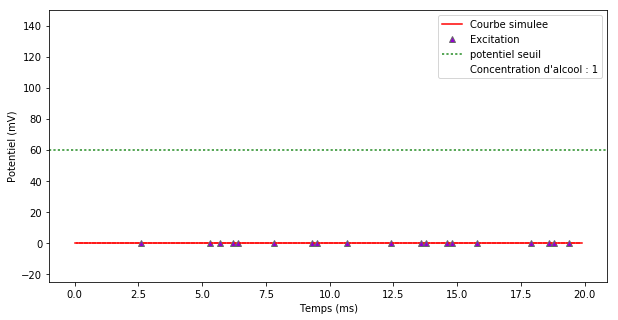

In [288]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_xlabel("Temps (ms)")
ax.set_ylabel('Potentiel (mV)')

ax.set_ylim([min(Vmin,Vmin_ma)-5 , Vmax+30])



for k in range(len(res_pot)-1):
    if(k in Lstimu):
        plt.plot([temps[k],temps[k+1]],[res_pot[k],res_pot[k+1]],color='red',marker="^",markerfacecolor="darkviolet",markeredgecolor="dimgrey",markevery=2,markersize=6)
    else:
        plt.plot([temps[k],temps[k+1]],[res_pot[k],res_pot[k+1]],color='red')


marker = mlines.Line2D([], [], marker='^', markersize=6,markerfacecolor="darkviolet",markeredgecolor="dimgrey",linestyle='None',label="Excitation")
alcool=l=mlines.Line2D([], [], color='white',label="Concentration d'alcool : "+str(ca))
l=mlines.Line2D([], [], color='red',label="Courbe simulee")
line_seuil=plt.axhline(y=Vseuil,color="forestgreen",linestyle=':',label="potentiel seuil")

ax.legend(handles=[l,marker,line_seuil,alcool])
plt.show()
fig.savefig("test.pdf")
fig.savefig("test.png",bbox_inches='tight')




### Sauvegarde des données pour les réunir ensuite

In [289]:
mon_fichier = open("test.txt", "w")
label="N= "+str(len(C))+"\nVseuil= "+str(Vseuil)+"\nVmax= "+str(Vmax)+"\nVmin= "+str(Vmin)+"\nVmin_ma= "+str(Vmin_ma)
label=label+"\ntau_min= "+str(tau_min)+"\ntau_max= "+str(tau_max)+"\ntPA= "+str(tPA)+"\ndeltaT= "+str(deltaT)
label=label+"\ntPH= "+str(tPH)+"\ntH= "+str(tH)+"\nalpha= "+str(alpha)+"\nbeta= "+str(beta)+"\n\nca= "+str(ca)

label=label+"\n\n"+"temps= "+str(temps)+"\n\npotentiel= "+str(res_pot)+"\n\nstimulation= "+str(Lstimu)

label=label+"\n\n\nC= "+write_matrix(C)+"\n\nCn= "+write_matrix(Cn)+"\n\nCe= "+write_matrix(Cn)+"\n\nCi= "+write_matrix(Cn)


mon_fichier.write(label)
mon_fichier.close()
print("FAIT")

FAIT


### Union des courbes

In [279]:
Lca=[0,1]
Color=["forestgreen","crimson"]
#Color=["forestgreen","c","darkslateblue","darkorange","crimson"]

temps_sans_alcool= temps= [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0, 4.1000000000000005, 4.2, 4.3, 4.4, 4.5, 4.6000000000000005, 4.7, 4.800000000000001, 4.9, 5.0, 5.1000000000000005, 5.2, 5.300000000000001, 5.4, 5.5, 5.6000000000000005, 5.7, 5.800000000000001, 5.9, 6.0, 6.1000000000000005, 6.2, 6.300000000000001, 6.4, 6.5, 6.6000000000000005, 6.7, 6.800000000000001, 6.9, 7.0, 7.1000000000000005, 7.2, 7.300000000000001, 7.4, 7.5, 7.6000000000000005, 7.7, 7.800000000000001, 7.9, 8.0, 8.1, 8.200000000000001, 8.3, 8.4, 8.5, 8.6, 8.700000000000001, 8.8, 8.9, 9.0, 9.1, 9.200000000000001, 9.3, 9.4, 9.5, 9.600000000000001, 9.700000000000001, 9.8, 9.9, 10.0, 10.100000000000001, 10.200000000000001, 10.3, 10.4, 10.5, 10.600000000000001, 10.700000000000001, 10.8, 10.9, 11.0, 11.100000000000001, 11.200000000000001, 11.3, 11.4, 11.5, 11.600000000000001, 11.700000000000001, 11.8, 11.9, 12.0, 12.100000000000001, 12.200000000000001, 12.3, 12.4, 12.5, 12.600000000000001, 12.700000000000001, 12.8, 12.9, 13.0, 13.100000000000001, 13.200000000000001, 13.3, 13.4, 13.5, 13.600000000000001, 13.700000000000001, 13.8, 13.9, 14.0, 14.100000000000001, 14.200000000000001, 14.3, 14.4, 14.5, 14.600000000000001, 14.700000000000001, 14.8, 14.9, 15.0, 15.100000000000001, 15.200000000000001, 15.3, 15.4, 15.5, 15.600000000000001, 15.700000000000001, 15.8, 15.9, 16.0, 16.1, 16.2, 16.3, 16.400000000000002, 16.5, 16.6, 16.7, 16.8, 16.900000000000002, 17.0, 17.1, 17.2, 17.3, 17.400000000000002, 17.5, 17.6, 17.7, 17.8, 17.900000000000002, 18.0, 18.1, 18.2, 18.3, 18.400000000000002, 18.5, 18.6, 18.7, 18.8, 18.900000000000002, 19.0, 19.1, 19.200000000000003, 19.3, 19.400000000000002, 19.5, 19.6, 19.700000000000003, 19.8, 19.900000000000002, 20.0, 20.1, 20.200000000000003, 20.3, 20.400000000000002, 20.5, 20.6, 20.700000000000003, 20.8, 20.900000000000002, 21.0, 21.1, 21.200000000000003]
res_pot_sans_alcool= [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8905492543463109, 5.2227473791476688, 10.049791822324725, 16.557998164119496, 23.31211898801039, 25.514052646327094, 23.981973600366313, 19.483681746899716, 12.965072717385379, 7.062665237445648, 3.4926118021434394, 1.6022620131230398, 0.70157385549845219, 0.29983991206143246, 0.12671067739512523, 0.053282527700391179, 0.022357276669293578, 0.0093742830510866564, 0.0039268330111675723, 0.0016467471202277154, 0.0006913366770801004, 0.00028909638111849248, 0.00012150286680548708, 5.0276800485279873e-05, 2.0948624345728915e-05, 8.3794424485970884e-06, 4.1897200093485498e-06, -2.4680145235636037, -3.2159633925825064, -20.0, -20.0, -20.0, 4.9331725984230559, 60.0, 73.333333333333329, 86.666666666666657, 99.999999999999986, 113.33333333333331, 120.0, 106.66666666666667, 93.333333333333343, 80.000000000000014, 66.666666666666686, 60.0, 6.9612668079674282, -3.2665158480395085, -3.0569843994012724, -1.3114018917355654, -0.59230127060399607, -0.27276593657313758, -0.12666734202010901, -0.059043358907357582, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -2.0451303651271453, -0.90462410223504874, -0.41314240848032024, -0.19115462447838219, -0.08895175253382652, -0.041501260429996849, -1.8175020024153421, -3.2725451422650256, -3.3089044266789212, -2.8394892057937504, -2.838321289051625, -3.3399841271640338, -2.4830487822839906, -1.3064823751324748, 0.3440901529669248, 1.3252013984302164, 0.97178643375333662, 0.41841944710022083, 0.17741663541627226, 0.07471515675892583, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -2.0451303651271453, -0.90462410223504874, -0.41314240848032024, -0.19115462447838219, -0.08895175253382652, -0.041501260429996849, -0.019385982756285686, -0.0090627774411444657, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -2.0451303651271453, -0.90462410223504874, -0.41314240848032024, 18.426169361689787, 60.0, 73.333333333333329, 86.666666666666657, 99.999999999999986, 113.33333333333331, 120.0, 106.66666666666667, 93.333333333333343, 80.000000000000014, 66.666666666666686, 60.0, 24.393560181474449, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -2.0451303651271453, -2.9556019728444078, -3.1404112980477463, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -2.0451303651271453, -0.90462410223504874, -0.41314240848032024, -0.19115462447838219, -0.08895175253382652, -0.041501260429996849, -0.019385982756285686, -0.0090627774411444657, -0.0042357027693046868, -0.0019825136941455548, -0.00092584951298742117, -0.00043488028080307232, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -2.3159356688886965, -1.7398448064075633, -2.6403754711949663, -3.3547187118342028, -2.4490796386958356, -3.2511064443118523, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -2.0451303651271453, -0.90462410223504874, -0.41314240848032024, -0.19115462447838219, -0.08895175253382652, -0.041501260429996849, -0.019385982756285686, -0.0090627774411444657, -0.0042357027693046868]

temps_alcool= [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0, 4.1000000000000005, 4.2, 4.3, 4.4, 4.5, 4.6000000000000005, 4.7, 4.800000000000001, 4.9, 5.0, 5.1000000000000005, 5.2, 5.300000000000001, 5.4, 5.5, 5.6000000000000005, 5.7, 5.800000000000001, 5.9, 6.0, 6.1000000000000005, 6.2, 6.300000000000001, 6.4, 6.5, 6.6000000000000005, 6.7, 6.800000000000001, 6.9, 7.0, 7.1000000000000005, 7.2, 7.300000000000001, 7.4, 7.5, 7.6000000000000005, 7.7, 7.800000000000001, 7.9, 8.0, 8.1, 8.200000000000001, 8.3, 8.4, 8.5, 8.6, 8.700000000000001, 8.8, 8.9, 9.0, 9.1, 9.200000000000001, 9.3, 9.4, 9.5, 9.600000000000001, 9.700000000000001, 9.8, 9.9, 10.0, 10.100000000000001, 10.200000000000001, 10.3, 10.4, 10.5, 10.600000000000001, 10.700000000000001, 10.8, 10.9, 11.0, 11.100000000000001, 11.200000000000001, 11.3, 11.4, 11.5, 11.600000000000001, 11.700000000000001, 11.8, 11.9, 12.0, 12.100000000000001, 12.200000000000001, 12.3, 12.4, 12.5, 12.600000000000001, 12.700000000000001, 12.8, 12.9, 13.0, 13.100000000000001, 13.200000000000001, 13.3, 13.4, 13.5, 13.600000000000001, 13.700000000000001, 13.8, 13.9, 14.0, 14.100000000000001, 14.200000000000001, 14.3, 14.4, 14.5, 14.600000000000001, 14.700000000000001, 14.8, 14.9, 15.0, 15.100000000000001, 15.200000000000001, 15.3, 15.4, 15.5, 15.600000000000001, 15.700000000000001, 15.8, 15.9, 16.0, 16.1, 16.2, 16.3, 16.400000000000002, 16.5, 16.6, 16.7, 16.8, 16.900000000000002, 17.0, 17.1, 17.2, 17.3, 17.400000000000002, 17.5, 17.6, 17.7, 17.8, 17.900000000000002, 18.0, 18.1, 18.2, 18.3, 18.400000000000002, 18.5, 18.6, 18.7, 18.8, 18.900000000000002, 19.0, 19.1, 19.200000000000003, 19.3, 19.400000000000002, 19.5, 19.6, 19.700000000000003, 19.8, 19.900000000000002]
res_pot_alcool= [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8905492543463109, 5.2227473791476688, 10.049791822324725, 16.557998164119496, 23.31211898801039, 25.514052646327094, 23.981973600366313, 19.483681746899716, 12.965072717385379, 7.062665237445648, 3.4926118021434394, 1.6022620131230398, 0.70157385549845219, 0.29983991206143246, 0.12671067739512523, 0.053282527700391179, 0.022357276669293578, 0.0093742830510866564, 0.0039268330111675723, 0.0016467471202277154, 0.0006913366770801004, 0.00028909638111849248, 0.00012150286680548708, 5.0276800485279873e-05, 2.0948624345728915e-05, 8.3794424485970884e-06, 4.1897200093485498e-06, -2.4680145235636037, -3.2159633925825064, -20.0, -20.0, -20.0, 4.9331725984230559, 60.0, 73.333333333333329, 86.666666666666657, 99.999999999999986, 113.33333333333331, 120.0, 106.66666666666667, 93.333333333333343, 80.000000000000014, 66.666666666666686, 60.0, 48.333333333333329, 36.666663333333332, 24.999993333333332, 13.333323333333333, 1.6666533333333327, -10.0, -9.0909090909090917, -8.1818190909090909, -7.2727290909090909, -6.363639090909091, -5.454549090909091, -4.5454590909090911, -3.6363690909090911, -2.7272790909090907, -1.8181890909090908, -0.90909909090909091, -9.0909090909585544e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8905492543463109, 5.2227473791476688, 10.049791822324725, 16.557998164119496, 23.31211898801039, 25.514052646327094, 23.981973600366313, 19.483681746899716, 12.965072717385379, 7.062665237445648, 3.4926118021434394, 1.6022620131230398, -1.9803543446210929, -3.2783852589363813, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -2.0451303651271453, -0.90462410223504874, -0.41314240848032024, -0.19115462447838219, -0.08895175253382652, -0.041501260429996849, -0.019385982756285686, -0.0090627774411444657, -0.0042357027693046868, -0.0019825136941455548, -0.00092584951298742117, -0.00043488028080307232, -0.0002010762255880823, -9.3524370864821594e-05, -4.2086084183954407e-05, -1.8704949999817486e-05, -9.3524797390694382e-06, -4.6762410543241572e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

T=[temps_sans_alcool,temps_alcool]
R=[res_pot_sans_alcool,res_pot_alcool]

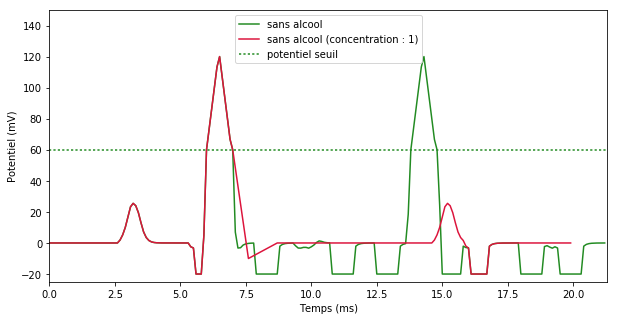

In [290]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_xlabel("Temps (ms)")
ax.set_ylabel('Potentiel (mV)')

ax.set_ylim([min(Vmin,Vmin_ma)-5 , Vmax+30])
ax.set_xlim([0,max(len(temps_sans_alcool),len(temps_alcool))*deltaT])

for l in range(len(Lca)):
    plt.plot(T[l],R[l],color=Color[l])


lsansAlcool=mlines.Line2D([], [], color=Color[0],label="sans alcool")
lalcool=mlines.Line2D([], [], color=Color[1],label="sans alcool (concentration : "+str(Lca[1])+")")
line_seuil=plt.axhline(y=Vseuil,color="forestgreen",linestyle=':',label="potentiel seuil")

ax.legend(handles=[lsansAlcool,lalcool,line_seuil])
plt.show()
fig.savefig("test.pdf")
fig.savefig("test.png",bbox_inches='tight')


### Animation

In [152]:
fig, ax= plt.subplots()
plt.plot(temps0,res_pot0,color='forestgreen')

ca=0.8

marker = mlines.Line2D([], [], marker='^', markersize=6,markerfacecolor="darkviolet",markeredgecolor="dimgrey",linestyle='None',label="Excitation")
l=mlines.Line2D([], [], color='red',label="avec alcool (concentration : "+str(ca)+")")
l2=mlines.Line2D([], [], color='forestgreen',label="sans alcool")
line_seuil=plt.axhline(y=Vseuil,color="forestgreen",linestyle=':',label="potentiel seuil")

ax.legend(handles=[l,l2,marker,line_seuil])


line,=ax.plot(0, 0, color='red')
line2,=ax.plot(0, 0, color='k')
line.axes.axis([0,len(temps)*deltaT+1,min(Vmin,Vmin_ma)-5 , Vmax+90])
line.axes.set_xlabel("Temps (ms)")
line.axes.set_ylabel('Potentiel (mV)')

def animate(i):
    line.set_data(temps[:i],res_pot[:i])
    
    line2.set_data([temps[i]],[res_pot[i]])
    line2.set_marker("^")
    line2.set_markerfacecolor("darkviolet")
    line2.set_markeredgecolor("dimgrey")
    
    if(i in Lstimu):
        line2.set_markersize(6)
    else:
        line2.set_markersize(0)
    return line,line2,

In [153]:
ani = animation.FuncAnimation(fig, animate,len(res_pot)-2, blit=False,)
ani.save("test.mp4",bitrate=-1,fps=5.5)
print("FAIT")

FAIT
